# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [2]:
pwd

'C:\\Users\\HP\\DATA_SCIENCE_COURSE_NOTES\\1. Projects_Assignment'

In [3]:
df = pd.read_csv('../1. Projects_Assignment/Frozen_Dessert_Production.csv', index_col='DATE', parse_dates = True)

df.tail()


,IPN31152N
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPN31152N,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


In [6]:
df=df.rename(columns = {'IPN31152N':'Production'})
# df.columns = ['Production']

<AxesSubplot:xlabel='DATE'>

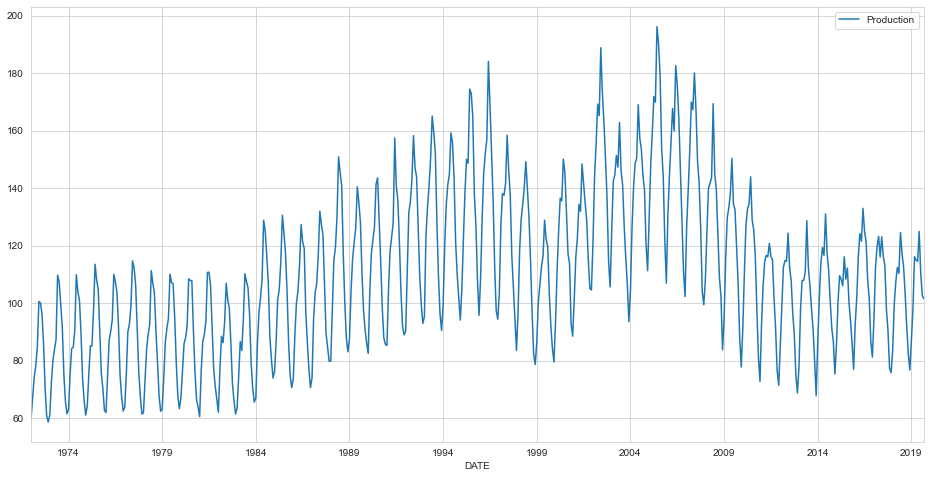

In [7]:
df.plot(figsize=(16,8))

## Preprocessing of Data

In [8]:
len(df)

573

In [9]:
test_size = 24

In [10]:
test_ind = len(df)- test_size
test_ind 

549

### Train Test Split

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [13]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [19]:
X, y = generator[0]

In [20]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
train_scaled.shape

(549, 1)

In [23]:
n_features = train_scaled.shape[1]

### Creating Model

### with "tanh" activation function

In [24]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [28]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [29]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 8s 8ms/step - loss: 0.0226 - val_loss: 0.0120
Epoch 2/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 5/20
537/537 [==============================] - 5s 8ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 8/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0038 - val_loss: 0.0022


<AxesSubplot:>

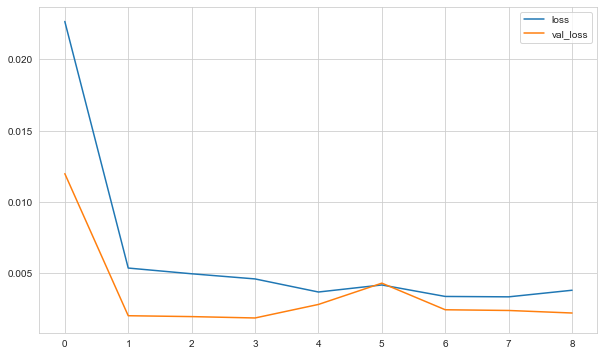

In [30]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [33]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:] # scaled train setinin sonundan aldım.
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):  # 12 tane predict yaptırıyorum.
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [34]:
eval_metrics(test_scaled[:length], predictions_scaled) 

r2_score: 0.6099069530304102 
mae: 0.057382492775596185 
mse: 0.004864709484664818 
rmse: 0.06974746937821341


#### Inverse Transformations and Comparing

In [35]:
predictions = scaler.inverse_transform(predictions_scaled)

In [36]:
compare = test[:12]

In [37]:
compare['Predictions'] = predictions

In [38]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,92.902
2017-11-01,77.438,89.256
2017-12-01,75.812,92.656
2018-01-01,83.434,100.444
2018-02-01,99.490,108.625
2018-03-01,107.315,115.265
2018-04-01,112.431,120.217
2018-05-01,110.354,122.498
2018-06-01,124.584,122.297


<AxesSubplot:xlabel='DATE'>

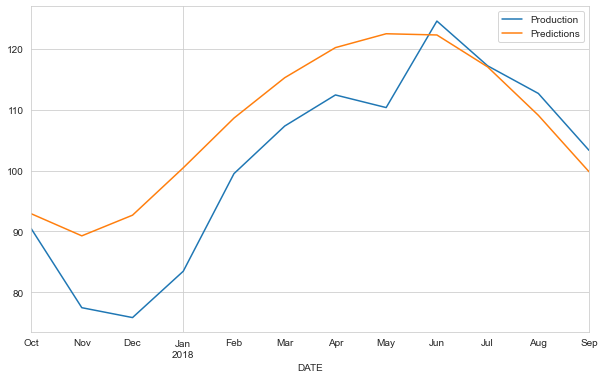

In [39]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [40]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.6099069530304105 
mae: 7.890890373294053 
mse: 91.9920099863598 
rmse: 9.591246529328698


### with "relu" activation function

In [41]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [43]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [44]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [45]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 6s 7ms/step - loss: 0.0280 - val_loss: 0.0050
Epoch 2/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 3/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 4/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 5/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 6/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 7/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 8/20
537/537 [==============================] - 4s 8ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 10/20
537/537 [==============================] - 4s 7ms/step - loss: 0.0035 - val_loss: 0.0032

<AxesSubplot:>

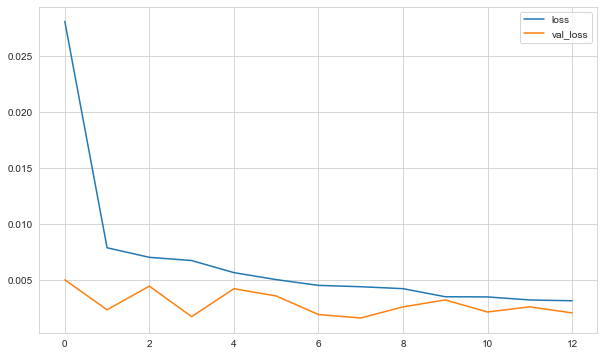

In [46]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [47]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [48]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:] # scaled train setinin sonundan aldım.
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):  # 12 tane predict yaptırıyorum.
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [49]:
eval_metrics(test_scaled[:length], predictions_scaled) 

r2_score: 0.820567761163308 
mae: 0.044457231764869896 
mse: 0.002237634638464976 
rmse: 0.04730364297244955


#### Inverse Transformations and Comparing

In [50]:
predictions = scaler.inverse_transform(predictions_scaled)

In [51]:
compare = test[:12]

In [52]:
compare['Predictions'] = predictions

In [53]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,92.965
2017-11-01,77.438,84.242
2017-12-01,75.812,82.017
2018-01-01,83.434,93.650
2018-02-01,99.490,105.778
2018-03-01,107.315,113.353
2018-04-01,112.431,116.767
2018-05-01,110.354,118.438
2018-06-01,124.584,119.002


<AxesSubplot:xlabel='DATE'>

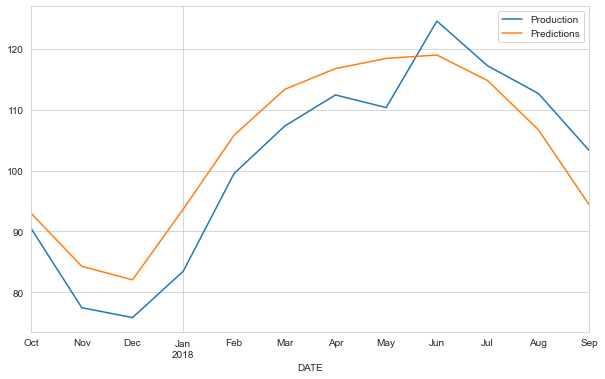

In [54]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [55]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.8205677611633082 
mae: 6.113487323191138 
mse: 42.313833674217314 
rmse: 6.504908429349126


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [56]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [57]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [58]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 6s 7ms/step - loss: 0.0267
Epoch 2/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0106
Epoch 3/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0072
Epoch 4/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0063
Epoch 5/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0061
Epoch 6/15
561/561 [==============================] - 4s 8ms/step - loss: 0.0053
Epoch 7/15
561/561 [==============================] - 4s 8ms/step - loss: 0.0054
Epoch 8/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0042
Epoch 9/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0042
Epoch 10/15
561/561 [==============================] - 4s 8ms/step - loss: 0.0039
Epoch 11/15
561/561 [==============================] - 4s 8ms/step - loss: 0.0037
Epoch 12/15
561/561 [==============================] - 4s 7ms/step - loss: 0.0036
Epoch 13/15
561/561 [====

In [59]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [60]:
forecast = scaler.inverse_transform(forecast)

In [61]:
forecast_index = pd.date_range(start = '2019-09-01', periods = length, freq = 'MS')

In [62]:
forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [63]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

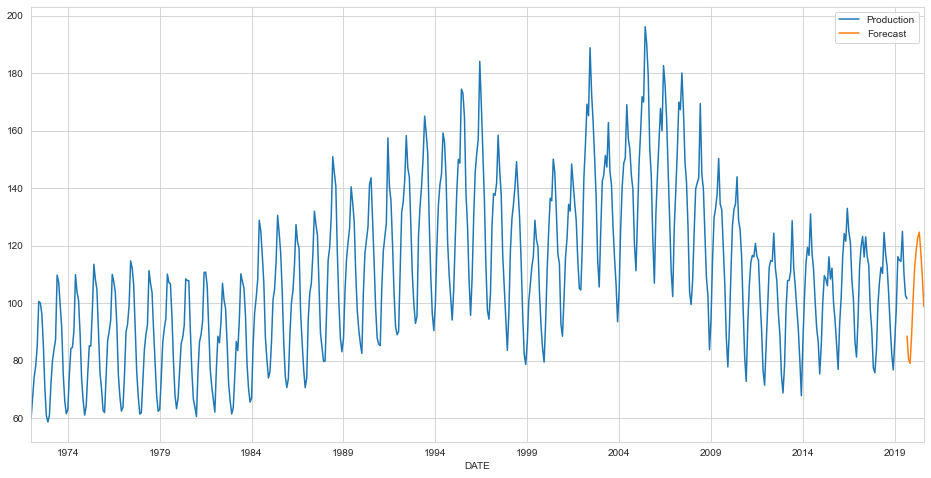

In [64]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(588.0, 600.0)

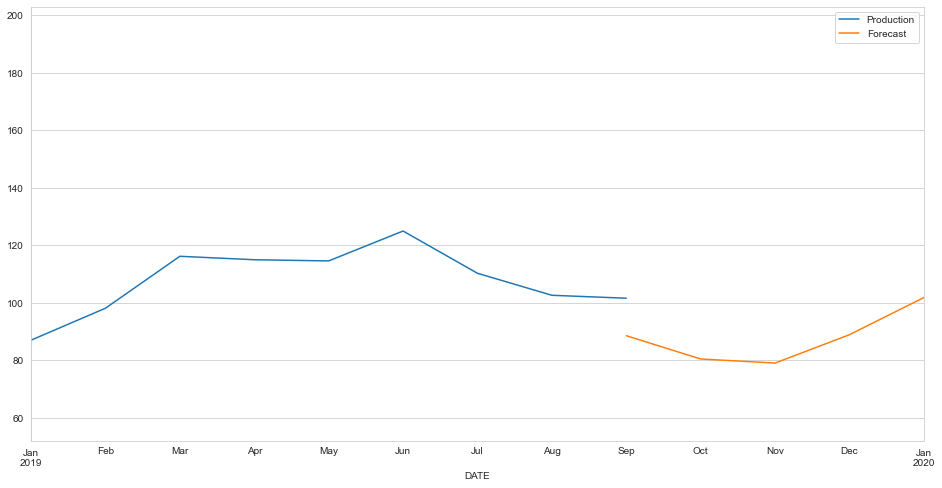

In [65]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2019-01-01', '2020-01-01')

In [66]:
dataset_total = pd.concat((df['Production'], forecast_df['Forecast']), axis=0)

<AxesSubplot:>

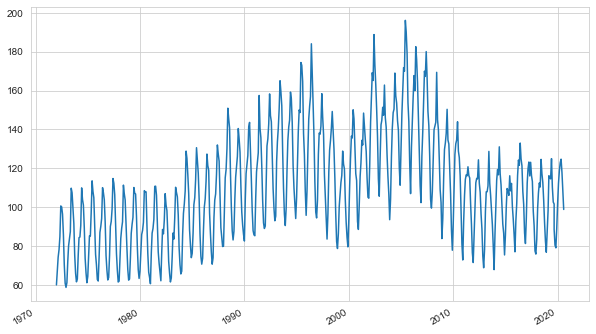

In [67]:
dataset_total.plot()